In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipdb
import os
import bda_utils

# Load data

In [2]:
Xs, Xt = bda_utils.load_data(if_weekday=1, if_interdet=1)
Xs = Xs[:,8:9]
Xt = Xt[:,8:9]
Xs, Xs_min, Xs_max = bda_utils.normalize2D(Xs)
Xt, Xt_min, Xt_max = bda_utils.normalize2D(Xt)

In [3]:
label_seq_len = 7
# batch_size = full batch
seq_len = 12
reduced_dim = 4
inp_dim = min(Xs.shape[1], Xt.shape[1])
label_dim = min(Xs.shape[1], Xt.shape[1])
hid_dim = 12
layers = 1
lamb = 2
MU = 0.7
bda_dim = label_seq_len-4
kernel_type = 'linear'

hyper = {
    'inp_dim':inp_dim,
    'label_dim':label_dim,
    'label_seq_len':label_seq_len,
    'seq_len':seq_len,
    'reduced_dim':reduced_dim,
    'hid_dim':hid_dim,
    'layers':layers,
    'lamb':lamb,
    'MU': MU,
    'bda_dim':bda_dim,
    'kernel_type':kernel_type}

hyper = pd.DataFrame(hyper, index=['Values'])
hyper

,inp_dim,label_dim,label_seq_len,seq_len,reduced_dim,hid_dim,layers,lamb,MU,bda_dim,kernel_type
Values,1,1,7,12,4,12,1,2,0.7,3,linear


In [4]:
Xs = Xs[:96, :]

# [sample size, seq_len, inp_dim (dets)], [sample size, label_seq_len, inp_dim (dets)]
Xs_3d, Ys_3d = bda_utils.sliding_window(Xs, Xs, seq_len, label_seq_len)  
Xt_3d, Yt_3d = bda_utils.sliding_window(Xt, Xt, seq_len, label_seq_len)
Ys_3d = Ys_3d[:, label_seq_len-1:, :]
Yt_3d = Yt_3d[:, label_seq_len-1:, :]
print(Xs_3d.shape)
print(Ys_3d.shape)
print(Xt_3d.shape)
print(Yt_3d.shape)

(78, 12, 1)
(78, 1, 1)
(462, 12, 1)
(462, 1, 1)


In [5]:

Xs_train_3d = []
Ys_train_3d = []
Xt_valid_3d = []
Xt_train_3d = []
Yt_valid_3d = []
Yt_train_3d = []

for i in range(Xs_3d.shape[2]):

#     bda = BDA(kernel_type='linear', dim=seq_len-reduced_dim, lamb=lamb, mu=0.6, gamma=1, T=1)  # T is iteration time
#     Xs_new, Xt_new, A = bda.fit(
#         Xs_3d[:, :, i], bda_utils.get_class(Ys_3d[:, :, i]), Xt_3d[:, :, i], bda_utils.get_class(Yt_3d[:, :, i])
#     )  # input shape: ns, n_feature | ns, n_label_feature
    Xs_new = Xs_3d[:, :, 0]
    Xt_new = Xt_3d[:, :, 0]

    day_train_t = 1
    Xs_train = Xs_new.copy()
    Ys_train = Ys_3d[:, :, i]
    Xt_valid = Xt_new.copy()[int(Xs_3d.shape[0]):, :]
    Xt_train = Xt_new.copy()[:int(Xs_3d.shape[0]), :]
    Yt_valid = Yt_3d[:, :, i].copy()[int(Xs_3d.shape[0]):, :]
    Yt_train = Yt_3d[:, :, i].copy()[:int(Xs_3d.shape[0]), :]
    
    Xs_train_3d.append(Xs_train)
    Ys_train_3d.append(Ys_train)
    Xt_valid_3d.append(Xt_valid)
    Xt_train_3d.append(Xt_train)
    Yt_valid_3d.append(Yt_valid)
    Yt_train_3d.append(Yt_train)


Xs_train_3d = np.array(Xs_train_3d)
Ys_train_3d = np.array(Ys_train_3d)
Xt_valid_3d = np.array(Xt_valid_3d)
Xt_train_3d = np.array(Xt_train_3d)
Yt_valid_3d = np.array(Yt_valid_3d)
Yt_train_3d = np.array(Yt_train_3d)

# bda_utils.save_np(Xs_train_3d, './outputs/BDA/Xs_new_%i.csv'%(bda_utils.get_num()-14/6))
# bda_utils.save_np(Ys_train_3d, './outputs/BDA/Xt_new_%i.csv'%(bda_utils.get_num()-14/6))
# bda_utils.save_np(Xt_valid_3d, './outputs/BDA/Xs_new_%i.csv'%(bda_utils.get_num()-14/6))
# bda_utils.save_np(Xt_train_3d, './outputs/BDA/Xt_new_%i.csv'%(bda_utils.get_num()-14/6))
# bda_utils.save_np(Yt_valid_3d, './outputs/BDA/Xs_new_%i.csv'%(bda_utils.get_num()-14/6))
# bda_utils.save_np(Yt_train_3d, './outputs/BDA/Xt_new_%i.csv'%(bda_utils.get_num()-14/6))


In [6]:
print(Xs_train.shape)
print(Ys_train.shape)
print(Xt_valid.shape)
print(Xt_train.shape)
print(Yt_valid.shape)
print(Yt_train.shape)

(78, 12)
(78, 1)
(384, 12)
(78, 12)
(384, 1)
(78, 1)


In [7]:
from sklearn.svm import LinearSVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

import xgboost as xgb

In [8]:
regr = make_pipeline(StandardScaler(),
...                      LinearSVR(random_state=0, tol=1e-7, max_iter=1e7))


In [9]:
regr.fit(Xt_train, Yt_train.flatten())

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvr',
                 LinearSVR(max_iter=10000000.0, random_state=0, tol=1e-07))])

In [10]:
g_t = Yt_valid.flatten()
pred = regr.predict(Xt_valid)

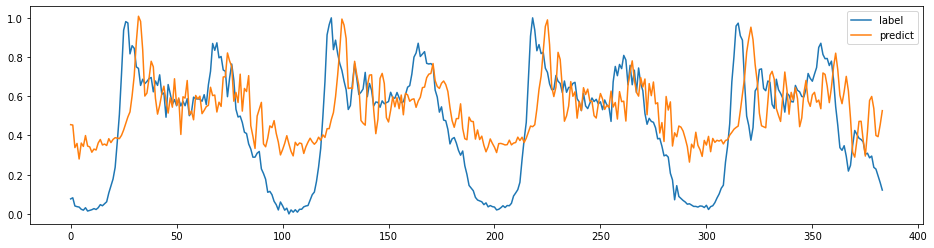

In [11]:
g_t = Yt_valid.flatten()
pred = regr.predict(Xt_valid)

plt.figure(figsize=[16,4])
plt.plot(g_t, label='label')
plt.plot(pred, label='predict')
plt.legend()

In [12]:
print(bda_utils.nrmse_loss_func(pred, g_t, 0))
print(bda_utils.mape_loss_func(pred, g_t, 0))

0.22898355330960166
2.168288606429537


C:\Users\10169\Documents\Github\BDA_traffic\bda_utils.py:76: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(eliminate_nan(np.fabs(labels[mask]-preds[mask])/labels[mask]))
